In [ ]:
!pip install ../input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install ../input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install ../input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install ../input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install ../input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl


In [ ]:
pip install git+https://github.com/ResidentMario/missingno.git

In [4]:
import pandas as pd
import numpy as np
import os

/Users/christang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/christang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [6]:
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer 
from sklearn.model_selection import train_test_split

In [7]:
import myutils.preprocessing as pp 
import myutils.visualization as vz
from metric import score as sc
%load_ext autoreload
%autoreload 2

In [8]:
from lifelines import KaplanMeierFitter

In [2]:
def read_data(data_dir,fileNames):
    path = os.path.join(data_dir,fileNames)
    df = pd.read_csv(path)
    return df

In [9]:
data_dir = '../input/data'
output_dir = '../output'

fName1 = 'train.csv'
fName2 = 'test.csv'
fName3 = 'data_dictionary.csv'

trainData = read_data(data_dir,fName1)
testData = read_data(data_dir,fName2)
dataDict = read_data(data_dir,fName3)

random_seed = 202501

# Data Understanding and Inspection

In [ ]:
print(trainData.head(5))

In [ ]:
print("Size of the df:",trainData.shape, "\nColumn Names:\n", trainData.columns)

In [ ]:
print("Size of the df:",testData.shape, "\nColumn Names:\n", testData.columns)

In [ ]:
print(trainData.info())

In [ ]:
vz.scatter_plot(trainData,'efs_time','efs')

In [ ]:
#inspecting missing values for the training set
print(trainData.isnull().sum().sort_values(ascending=False))

In [ ]:
#inspecting missing values for the test set
print(testData.isnull().sum().sort_values(ascending=False))

In [ ]:
#plot the missing values heatmap
vz.plot_missing_values(trainData)
vz.plot_missing_values(testData)

Due to the large number of missing values and unclearness of the patterns in the values that are missing, regular imputation methods will not be considered to use as the training accuracy could be severly impaired.

In [ ]:
#Understanding the missing values


#missing_values = pp.missing_val_df(trainData)
#missing_values = missing_values.merge(dataDict[['variable', 'description']], left_on='variables', right_on='variable', how='left')
#missing_values.drop(columns=['variable'], inplace=True)
#missing_values.rename(columns={'description': 'Variable Description'}, inplace=True)

#missing_values

In [ ]:
# Detect duplicate rows
#duplicate_rows = trainData[trainData.duplicated()]
# Show duplicate rows
#print(duplicate_rows)

No duplicated observations is discovered in the dataset

# Data Preprocessing

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder,OneHotEncoder

In [31]:
def prepare_data(trainData, testData, target_cols, id_col='ID'):
    feature_cols = [col for col in trainData.columns if col not in target_cols + [id_col]]

    X_train = trainData[feature_cols]
    y_train = trainData[target_cols]
    X_test = testData[feature_cols]
    return X_train, y_train, X_test


target_cols = ['efs', 'efs_time']

X_train, y_train, X_test = prepare_data(trainData, testData,target_cols)




In [35]:
def transform_suv_prob(df, time = 'efs_time', event = 'efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time], event_observed=df[event])
    survivals_prob = kmf.survival_function_at_times(df[time]).values
    return survivals_prob

def preprocess_data(X_train, y_train, X_test, num_cols, cat_cols, event_col='efs', time_col='efs_time'):
    
    X_train_copy = X_train.copy()
    y_train_copy = y_train.copy()

    num_pp = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        # ('scaler', StandardScaler()),
    ])

    cat_pp = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='UNKNOWN'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_pp, num_cols),
            ('cat', cat_pp, cat_cols)
        ],
        remainder='passthrough'  # Keep any other columns if necessary
    )

    X_train_processed = preprocessor.fit_transform(X_train_copy)
    X_test_processed = preprocessor.transform(X_test)

    processed_cols = num_cols + cat_cols
    X_train_processed = pd.DataFrame(X_train_processed, columns=processed_cols)
    X_test_processed = pd.DataFrame(X_test_processed, columns=processed_cols)



    train = pd.concat([X_train_processed, y_train_copy], axis=1)
    train['y'] = transform_suv_prob(train, time_col, event_col)

    agg = pd.concat([train, X_test_processed], axis=0, ignore_index=True)

    train = agg.iloc[:len(train)].copy()
    test = agg.iloc[len(train):].reset_index(drop=True).copy()

    for col in num_cols:
        train[col] = train[col].astype('float32')
        test[col] = test[col].astype('float32')
    for col in cat_cols:
        train[col] = train[col].astype('category')
        test[col] = X_test_processed[col].astype('category')

    return train, test, preprocessor

    


In [36]:
# Define columns


num_cols = pp.numeric_df(X_train).columns.tolist()  # Numerical columns
cat_cols = pp.get_cat_cols(X_train)                # Categorical columns

train,test,preprocessor = preprocess_data(
    X_train,
    y_train,
    X_test,
    num_cols,
    cat_cols
)

        


In [37]:
print(train.dtypes)
print(test.dtypes)

hla_match_c_high           float32
hla_high_res_8             float32
hla_low_res_6              float32
hla_high_res_6             float32
hla_high_res_10            float32
hla_match_dqb1_high        float32
hla_nmdp_6                 float32
hla_match_c_low            float32
hla_match_drb1_low         float32
hla_match_dqb1_low         float32
year_hct                   float32
hla_match_a_high           float32
donor_age                  float32
hla_match_b_low            float32
age_at_hct                 float32
hla_match_a_low            float32
hla_match_b_high           float32
comorbidity_score          float32
karnofsky_score            float32
hla_low_res_8              float32
hla_match_drb1_high        float32
hla_low_res_10             float32
dri_score                 category
psych_disturb             category
cyto_score                category
diabetes                  category
tbi_status                category
arrhythmia                category
graft_type          

In [ ]:
#We will perform data preprocessing on the numerical variables and categorical variables separately.

X_train_num = pp.numeric_df(X_train)
X_test_num = pp.numeric_df(X_test)

cat_colsTrain = pp.get_cat_cols(X_train)
X_train_cat = X_train[cat_colsTrain]

cat_colsTest = pp.get_cat_cols(X_test)
X_test_cat = X_test[cat_colsTest]



In [ ]:
#Plot the correlation heatmap between numerical variables to check for multicollinearity, 
#before we decide on which imputation method to use.
vz.cor_heatmap(X_train_num)

As we can see, the variables that starts with "hla" seems to be highly correlated with on another, while the other variables do not exhibited clear correlation.
Therefore, we decided to employ KNN (similarity based) imputer on all the variables that start with "hla" and Iterative imputer for the rest of the variables.

In [39]:
import math
n_cols = 2
n_plots = len(X_train_cat.columns)
n_rows = math.ceil(n_plots / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows))
axes = axes.flatten()

for i, cols in enumerate(X_train_cat.columns):
    sns.countplot(data=X_train_cat, x=cols, ax=axes[i])
    axes[i].set_title(cols)
    axes[i].tick_params(axis='x', rotation=90)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


NameError: name 'X_train_cat' is not defined

In [ ]:
import math
n_cols = 2
n_plots = len(X_test_cat.columns)
n_rows = math.ceil(n_plots / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows))
axes = axes.flatten()

for i, cols in enumerate(X_test_cat.columns):
    sns.countplot(data=X_test_cat, x=cols, ax=axes[i])
    axes[i].set_title(cols)
    axes[i].tick_params(axis='x', rotation=90)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
print(X_train.dtypes)
print(X_test.dtypes)

print(X_train.shape)
print(X_test.shape)


# Modeling

In [ ]:
%pip install xgboost

In [40]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import mean_squared_error

In [ ]:
RMV = ["ID","efs","efs_time","y"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

In [41]:
num_folds = 10
k_folds = KFold(n_splits=num_folds, shuffle=True, random_state=random_seed)

oof_xgb = np.zeros(len(train))
pred_xgb = np.zeros(len(test))

In [42]:
for i, (train_i,test_i) in enumerate(k_folds.split(train)):
    print("-"*10)
    print(f"-- Fold {i+1}")
    print("-"*25)
    
    x_train = train.loc[train_i,FEATURES].copy()
    y_train = train.loc[train_i,"y"]
    x_valid = train.loc[test_i,FEATURES].copy()
    y_valid = train.loc[test_i,"y"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=3,  
        colsample_bytree=0.5,  
        subsample=0.8,  
        n_estimators=2000,  
        learning_rate=0.02,  
        enable_categorical=True,
        min_child_weight=80,
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=500 
    )
    oof_xgb[test_i] = model_xgb.predict(x_valid)
    pred_xgb += model_xgb.predict(x_test) / num_folds

pred_xgb /= num_folds

----------
-- Fold 1
-------------------------
[0]	validation_0-rmse:0.17904


/Users/christang/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[500]	validation_0-rmse:0.16060
[1000]	validation_0-rmse:0.15833
[1500]	validation_0-rmse:0.15746
[1999]	validation_0-rmse:0.15702
----------
-- Fold 2
-------------------------
[0]	validation_0-rmse:0.17649


/Users/christang/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:46:22] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[500]	validation_0-rmse:0.15885
[1000]	validation_0-rmse:0.15718
[1500]	validation_0-rmse:0.15641
[1999]	validation_0-rmse:0.15604
----------
-- Fold 3
-------------------------
[0]	validation_0-rmse:0.17719


/Users/christang/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:46:28] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[500]	validation_0-rmse:0.16017
[1000]	validation_0-rmse:0.15845
[1500]	validation_0-rmse:0.15786
[1999]	validation_0-rmse:0.15760
----------
-- Fold 4
-------------------------
[0]	validation_0-rmse:0.17345


/Users/christang/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:46:34] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[500]	validation_0-rmse:0.15472
[1000]	validation_0-rmse:0.15285
[1500]	validation_0-rmse:0.15200
[1999]	validation_0-rmse:0.15165
----------
-- Fold 5
-------------------------
[0]	validation_0-rmse:0.17552


/Users/christang/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:46:41] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[500]	validation_0-rmse:0.15711
[1000]	validation_0-rmse:0.15538
[1500]	validation_0-rmse:0.15449
[1999]	validation_0-rmse:0.15412
----------
-- Fold 6
-------------------------
[0]	validation_0-rmse:0.17437


/Users/christang/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:46:47] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[500]	validation_0-rmse:0.15682
[1000]	validation_0-rmse:0.15495
[1500]	validation_0-rmse:0.15420
[1999]	validation_0-rmse:0.15392
----------
-- Fold 7
-------------------------
[0]	validation_0-rmse:0.17663


/Users/christang/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:46:54] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[500]	validation_0-rmse:0.15902
[1000]	validation_0-rmse:0.15731
[1500]	validation_0-rmse:0.15677
[1999]	validation_0-rmse:0.15642
----------
-- Fold 8
-------------------------
[0]	validation_0-rmse:0.17840


/Users/christang/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:47:00] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[500]	validation_0-rmse:0.16111
[1000]	validation_0-rmse:0.15922
[1500]	validation_0-rmse:0.15844
[1999]	validation_0-rmse:0.15809
----------
-- Fold 9
-------------------------
[0]	validation_0-rmse:0.17648


/Users/christang/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:47:07] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[500]	validation_0-rmse:0.15975
[1000]	validation_0-rmse:0.15791
[1500]	validation_0-rmse:0.15719
[1999]	validation_0-rmse:0.15687
----------
-- Fold 10
-------------------------
[0]	validation_0-rmse:0.17605


/Users/christang/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:47:13] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[500]	validation_0-rmse:0.16024
[1000]	validation_0-rmse:0.15898
[1500]	validation_0-rmse:0.15850
[1999]	validation_0-rmse:0.15824


In [ ]:
train.insert(0, 'ID', range(1, len(train) + 1))

In [46]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb
m = sc(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost KaplanMeier =",round(m,4))


/Users/christang/Desktop/kaggle/Scripts/metric.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost KaplanMeier = 0.6723


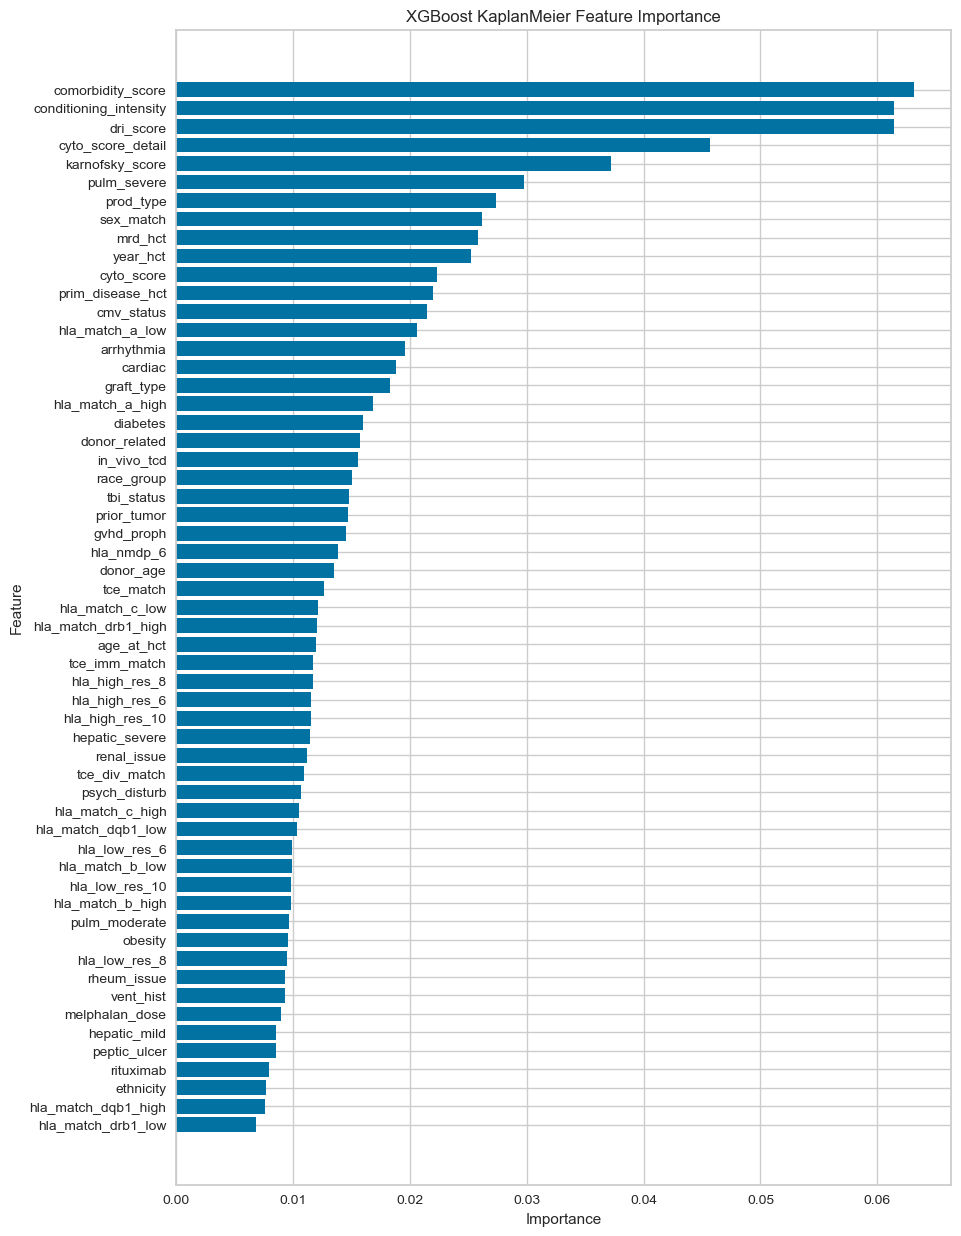

In [47]:
feature_importance = model_xgb.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,  # Replace FEATURES with your list of feature names
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost KaplanMeier Feature Importance")
plt.gca().invert_yaxis()  
plt.show()